# Tutorial : Dynap-SE1

Dynap-SE board consists of 4 chips, each having 4 cores inside. Each core harbors 64 Adaptive Exponential Integrate-and-Fire (AdExpIF) neurons, each with 64 fan-in. That means each AdExpIF neuron has a potential of 64 synapses to receive incoming connections of its presynaptic neurons. There are 4 types of synapses: AMPA, NMDA, GABA_A, and GABA_B.

Each core holds a `parameter group` to store the neuronal and synaptic parameters for its 64 neurons and their incoming synapses. The neurons in the same core share the same parameter values, including time constants, refractory periods, and weights. Therefore, different connection strengths between neurons can only be achieved by setting the same connection multiple times.

For spike input, 1024 spike generators, or virtual neurons, are available implemented on the FPGA. Each of the spike generators can be used as a Poisson spike generator or a normal FPGA spike generator. The overview of the architecture is summarized in figure below.

<img src=https://raw.githubusercontent.com/synsense/rockpool/dev/dynapse_support/docs/devices/DynapSE/images/dynapse_structure.png
 width="1024">

The connectivity and information delivery between neurons a two-stage tag-based routing scheme [1] is used. It’s a novel routing methodology to handle the asynchronous address-event traffic. In this tutorial detailed explanation of the routing mechanism is omitted. The simulator can be used by defining a simple weight matrices.

<!-- ![network](./images/network_v2.png) -->

[1] S. Moradi, N. Qiao, F. Stefanini, and G. Indiveri, “A scalable multicore architecture with heterogeneous memory structures for dynamic neuromorphic asynchronous processors (dynaps),” IEEE Transactions on Biomedical Circuits and Systems, vol. 12, no. 1, pp. 106–122, 2018.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Utils
from typing import Dict
import numpy as np
import json

# INI CodeBase
import sys
sys.path.append("/home/ugurc/SynSense Dropbox/Ugurcan Cakal/repos/dynapse1/ctxctl_contrib")
from netgen import Neuron, NetworkGenerator

# Samna
import samna.dynapse1 as dyn1

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential
from rockpool.nn.modules import TimedModuleWrapper

## Dynap-SE1
from rockpool.devices.dynapse.config.simconfig import DynapSimConfig, DynapSimCore
from rockpool.devices.dynapse.dynapsim import DynapSim
from rockpool.devices.dynapse.utils.figure import Figure
from rockpool.devices.dynapse.infrastructure.router import Router
from rockpool.devices.dynapse.utils.spike_input import poisson_spike_train


# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.1
 Built: Sep 28 2021 11:43:45

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



No protocol specified


## Utilities

In [2]:
# @title Printing { display-mode: "form" }


def print_json(
    __dict: Dict[str, np.ndarray], mean: bool = True, precision: int = 1
) -> None:
    """
    print_json gets a dictionary of numpy arrays and prints nicely converting it json

    :param __dict: dictionary to print
    :type __dict: Dict[str, np.ndarray]
    :param mean: take the mean values of the arrays or not, defaults to True
    :type mean: bool, optional
    :param precision: number of digits of precision for floating point output, defaults to 1
    :type precision: int, optional
    """

    if mean:
        __dict = {k: f"{v.mean():.{precision}e}" for k, v in __dict.items()}
    else:
        __dict = {k: list(v) for k, v in __dict.items()}
    jstring = json.dumps(__dict, indent=4)
    print(jstring)


## Configure the device

In [3]:
net_gen = NetworkGenerator()

spikegen_ids = [(0, 0, 50), (0, 0, 59), (0, 0, 78)]
spikegens = []
for spikegen_id in spikegen_ids:
    spikegens.append(Neuron(spikegen_id[0], spikegen_id[1], spikegen_id[2], True))

neuron_ids = [
    (1, 0, 20),
    (1, 0, 36),
    (1, 0, 60),
    (3, 0, 107),
    (3, 0, 152),
    (3, 0, 110),
]
neurons = []
for nid in neuron_ids:
    neurons.append(Neuron(nid[0], nid[1], nid[2]))


# connect neuron0 to other neurons
net_gen.add_connection(spikegens[0], neurons[0], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegens[0], neurons[1], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegens[0], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[0], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[1], neurons[3], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[1], neurons[4], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[2], neurons[2], dyn1.Dynapse1SynType.GABA_A)


net_gen.add_connection(neurons[4], neurons[0], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(neurons[4], neurons[0], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(neurons[0], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[1], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[4], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[2], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[2], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(neurons[0], neurons[4], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[4], neurons[3], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[4], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[5], dyn1.Dynapse1SynType.AMPA)

net_gen.network


Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C1c0n20: [('C0c0s50', 'AMPA'), ('C3c0n152', 'GABA_B'), ('C3c0n152', 'GABA_B')]
C1c0n36: [('C0c0s50', 'AMPA')]
C1c0n60: [('C0c0s50', 'NMDA'), ('C0c0s50', 'NMDA'), ('C0c0s78', 'GABA_A'), ('C1c0n20', 'AMPA'), ('C1c0n36', 'AMPA'), ('C3c0n152', 'AMPA'), ('C3c0n107', 'AMPA'), ('C1c0n60', 'AMPA'), ('C1c0n60', 'NMDA')]
C3c0n107: [('C0c0s59', 'NMDA'), ('C3c0n152', 'AMPA')]
C3c0n152: [('C0c0s59', 'NMDA'), ('C1c0n20', 'AMPA'), ('C3c0n107', 'AMPA')]
C3c0n110: [('C3c0n107', 'AMPA')]

In [4]:
config = net_gen.make_dynapse1_configuration()
simconfig = DynapSimConfig.from_Dynapse1Configuration(config)


In [5]:
simconfig.weight_bits


DynapSimWeightBits(Iw_0=array([0., 0., 0., 0., 0., 0.]), Iw_1=array([0., 0., 0., 0., 0., 0.]), Iw_2=array([0., 0., 0., 0., 0., 0.]), Iw_3=array([0., 0., 0., 0., 0., 0.]))

In [6]:
simconfig.time


DynapSimTime(t_pulse_ahp=array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06]), t_pulse=array([1.68396226e-05, 1.68396226e-05, 1.68396226e-05, 1.68396226e-05,
       1.68396226e-05, 1.68396226e-05]), t_ref=array([0.001785, 0.001785, 0.001785, 0.001785, 0.001785, 0.001785]), tau_ahp=array([9.04255319e-05, 9.04255319e-05, 9.04255319e-05, 9.04255319e-05,
       9.04255319e-05, 9.04255319e-05]), tau_ampa=array([0.36923759, 0.36923759, 0.36923759, 0.36923759, 0.36923759,
       0.36923759]), tau_gaba=array([0.37677305, 0.37677305, 0.37677305, 0.37677305, 0.37677305,
       0.37677305]), tau_nmda=None, tau_shunt=None, tau_mem=array([3617.0212766, 3617.0212766, 3617.0212766, 3617.0212766,
       3617.0212766, 3617.0212766]))

In [7]:
simconfig.gain


DynapSimGain(r_gain_ahp=array([1., 1., 1., 1., 1., 1.]), r_gain_ampa=None, r_gain_gaba=None, r_gain_nmda=None, r_gain_shunt=None, r_gain_mem=array([1.04e+08, 1.04e+08, 1.04e+08, 1.04e+08, 1.04e+08, 1.04e+08]))

In [8]:
router = Router.from_Dynapse1Configuration(config)
simconfig = DynapSimConfig.from_specification(
    shape=router.shape,
    w_in_mask=router.w_in_mask,
    w_rec_mask=router.w_rec_mask,
    w_out=router.w_out_mask,
)

in_shape = router.w_in_mask.shape
rec_shape = router.w_rec_mask.shape

w_in_linear = simconfig.w_in.reshape(in_shape[0], -1)

fpga = LinearJax(
    shape=w_in_linear.shape, weight=w_in_linear, has_bias=False, spiking_input=True
)

se1 = DynapSim.from_DynapSimConfig(
    shape=(rec_shape[2] * rec_shape[1], rec_shape[0]), simconfig=simconfig
)
modSE = TimedModuleWrapper(Sequential(fpga, se1), dt=se1.dt,)
modSE


TimedModuleWrapper  with shape (8, 6) {
    JaxSequential '_module' with shape (8, 6) {
        LinearJax '0_LinearJax' with shape (8, 24)
        DynapSim '1_DynapSim' with shape (24, 6)
    }
} with JaxSequential '_module' as module

## Input Spike Train

Generate an input spike train using utility functions provided `rockpool.devices.dynapse.utils.poisson_spike_train()` or `rockpool.devices.dynapse.utils.custom_spike_train()`

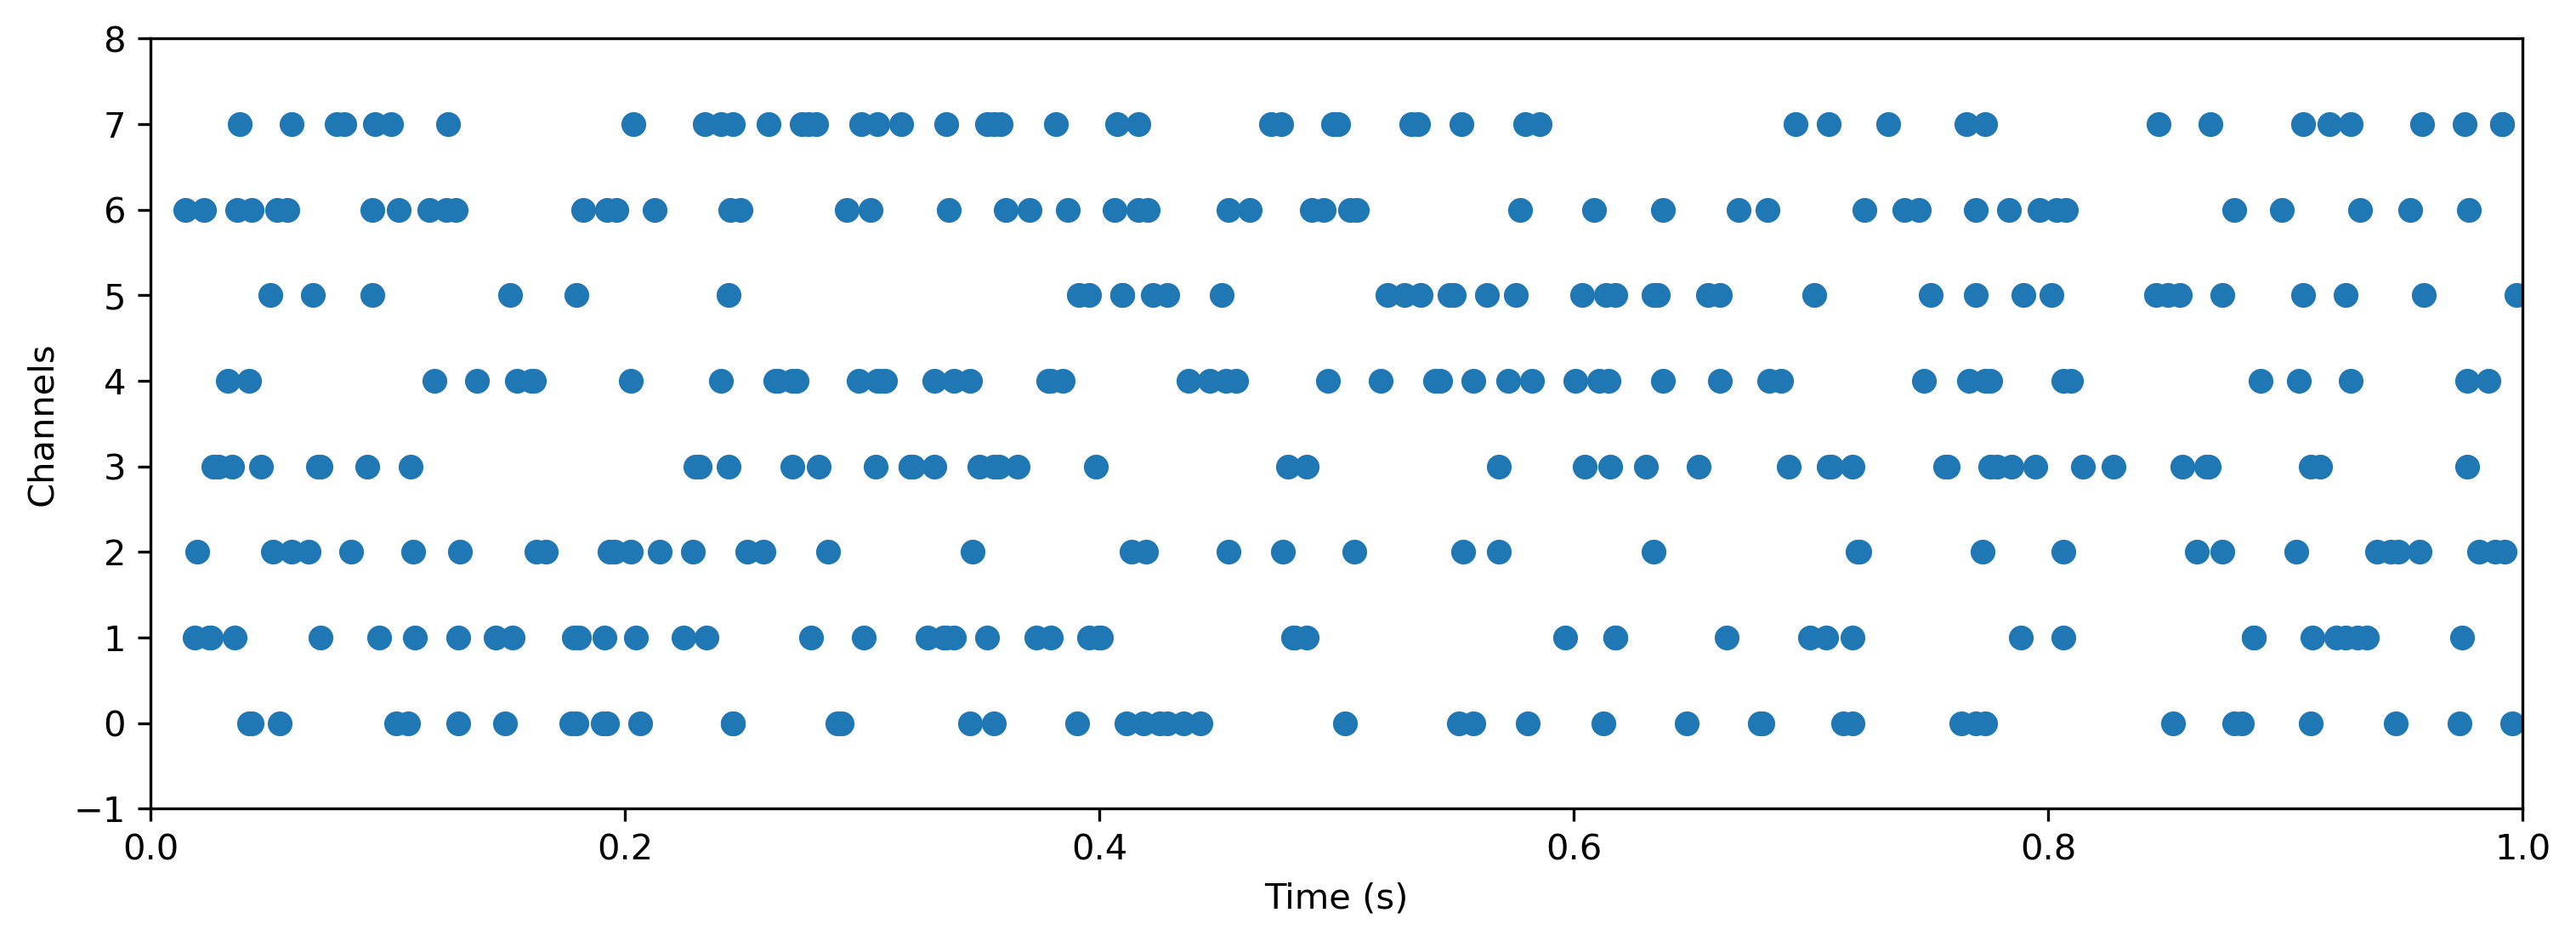

In [9]:
T = 1  # duration in seconds
rate = 50  # firing rate in Hertz

input_ts = poisson_spike_train(n_channels=8, duration=T, rate=rate, dt=modSE.dt)
input_ts = TSEvent.from_raster(input_ts, dt=modSE.dt)
input_ts.plot()



## Run the device simulator

Run the model to get output spikes, new_state and the record dictionary. Output spikes is the response of the system, new_state is the resulting state that the network got into, and the record dictionary stores the evolution of the currents. 

In [10]:
out_spikes, new_state, record_dict = modSE(input_ts, record=True)


# Visualize the State Change

In [11]:
rd = record_dict["1_DynapSim"]


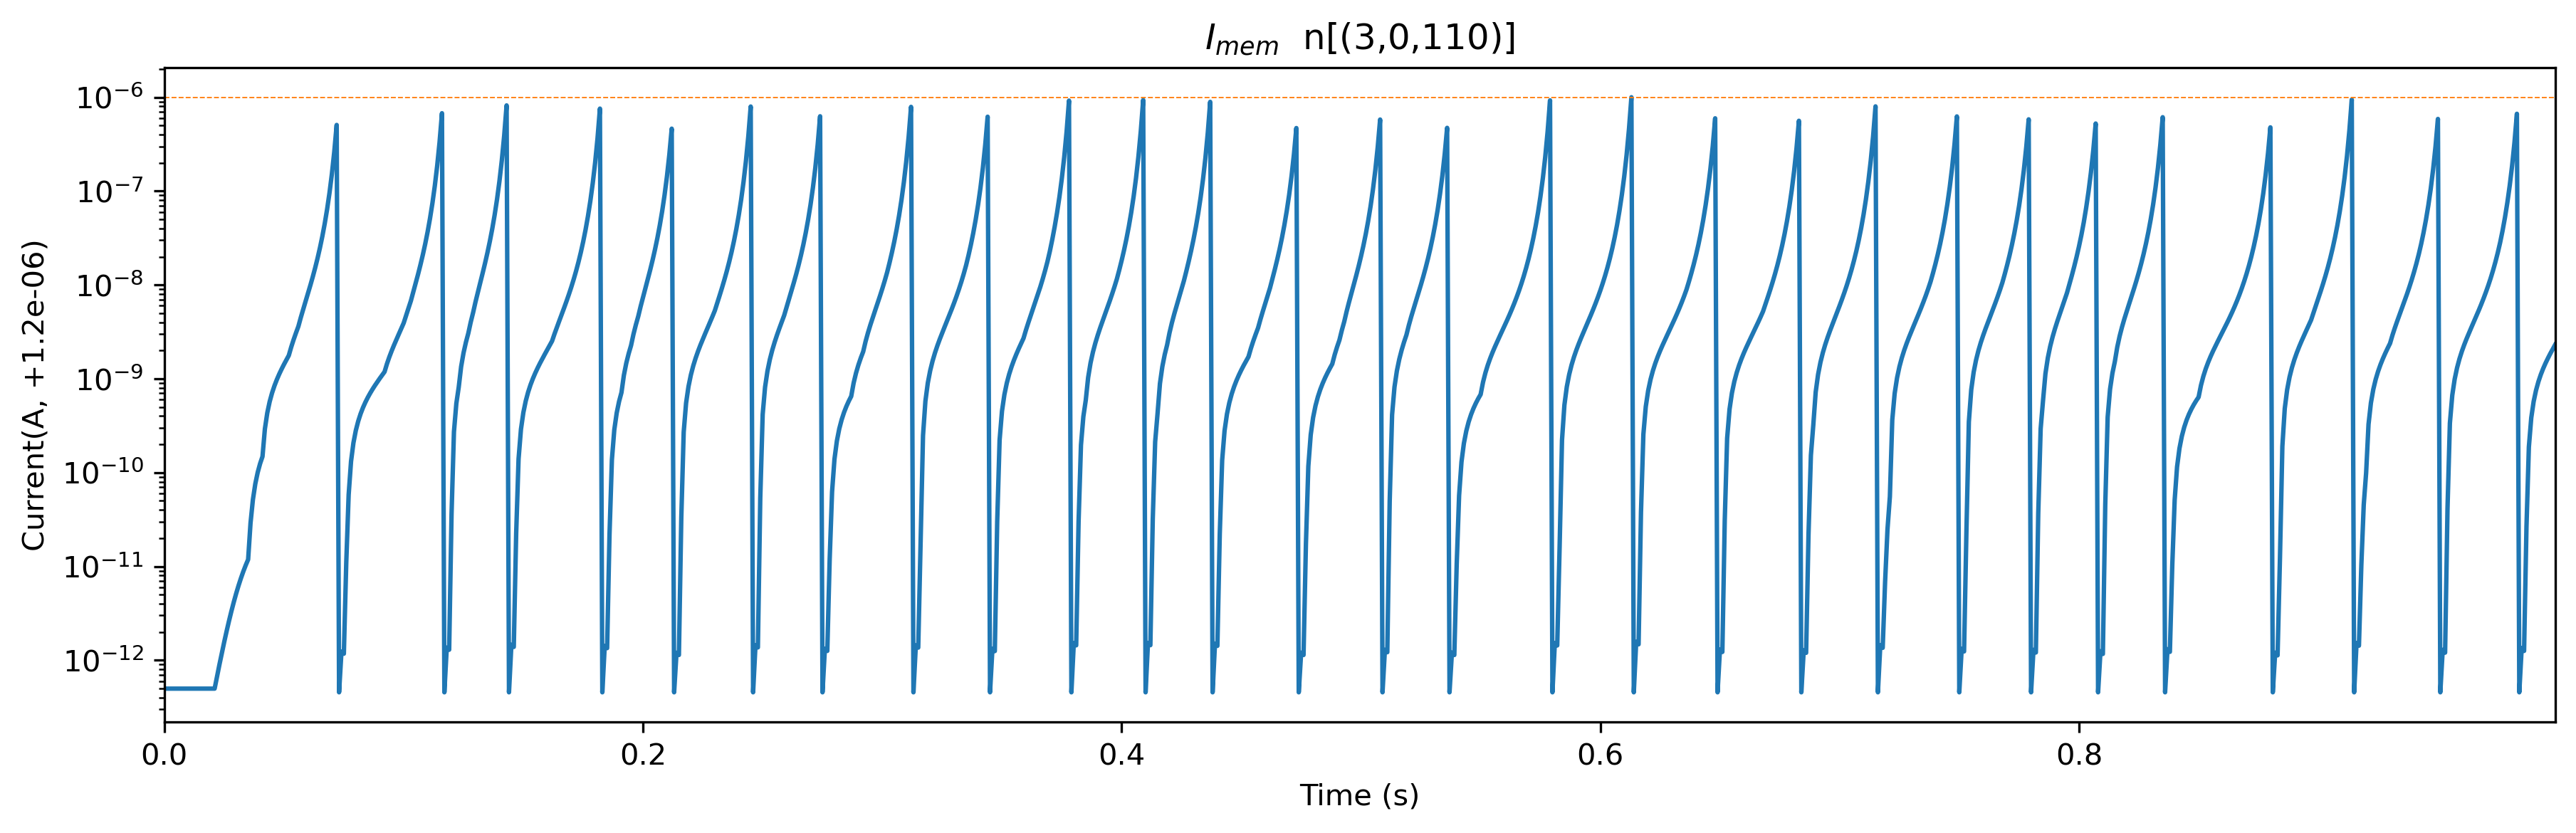

In [12]:
Figure.plot_Ix(rd["imem"][:, 4], se1.Ispkthr[4], name="$I_{mem}$  n[(3,0,110)]")
plt.yscale("log")



non-periodic TSContinuous object `$I_{mem}$` from t=0.0 to 1.0. Samples: 1000. Channels: 6

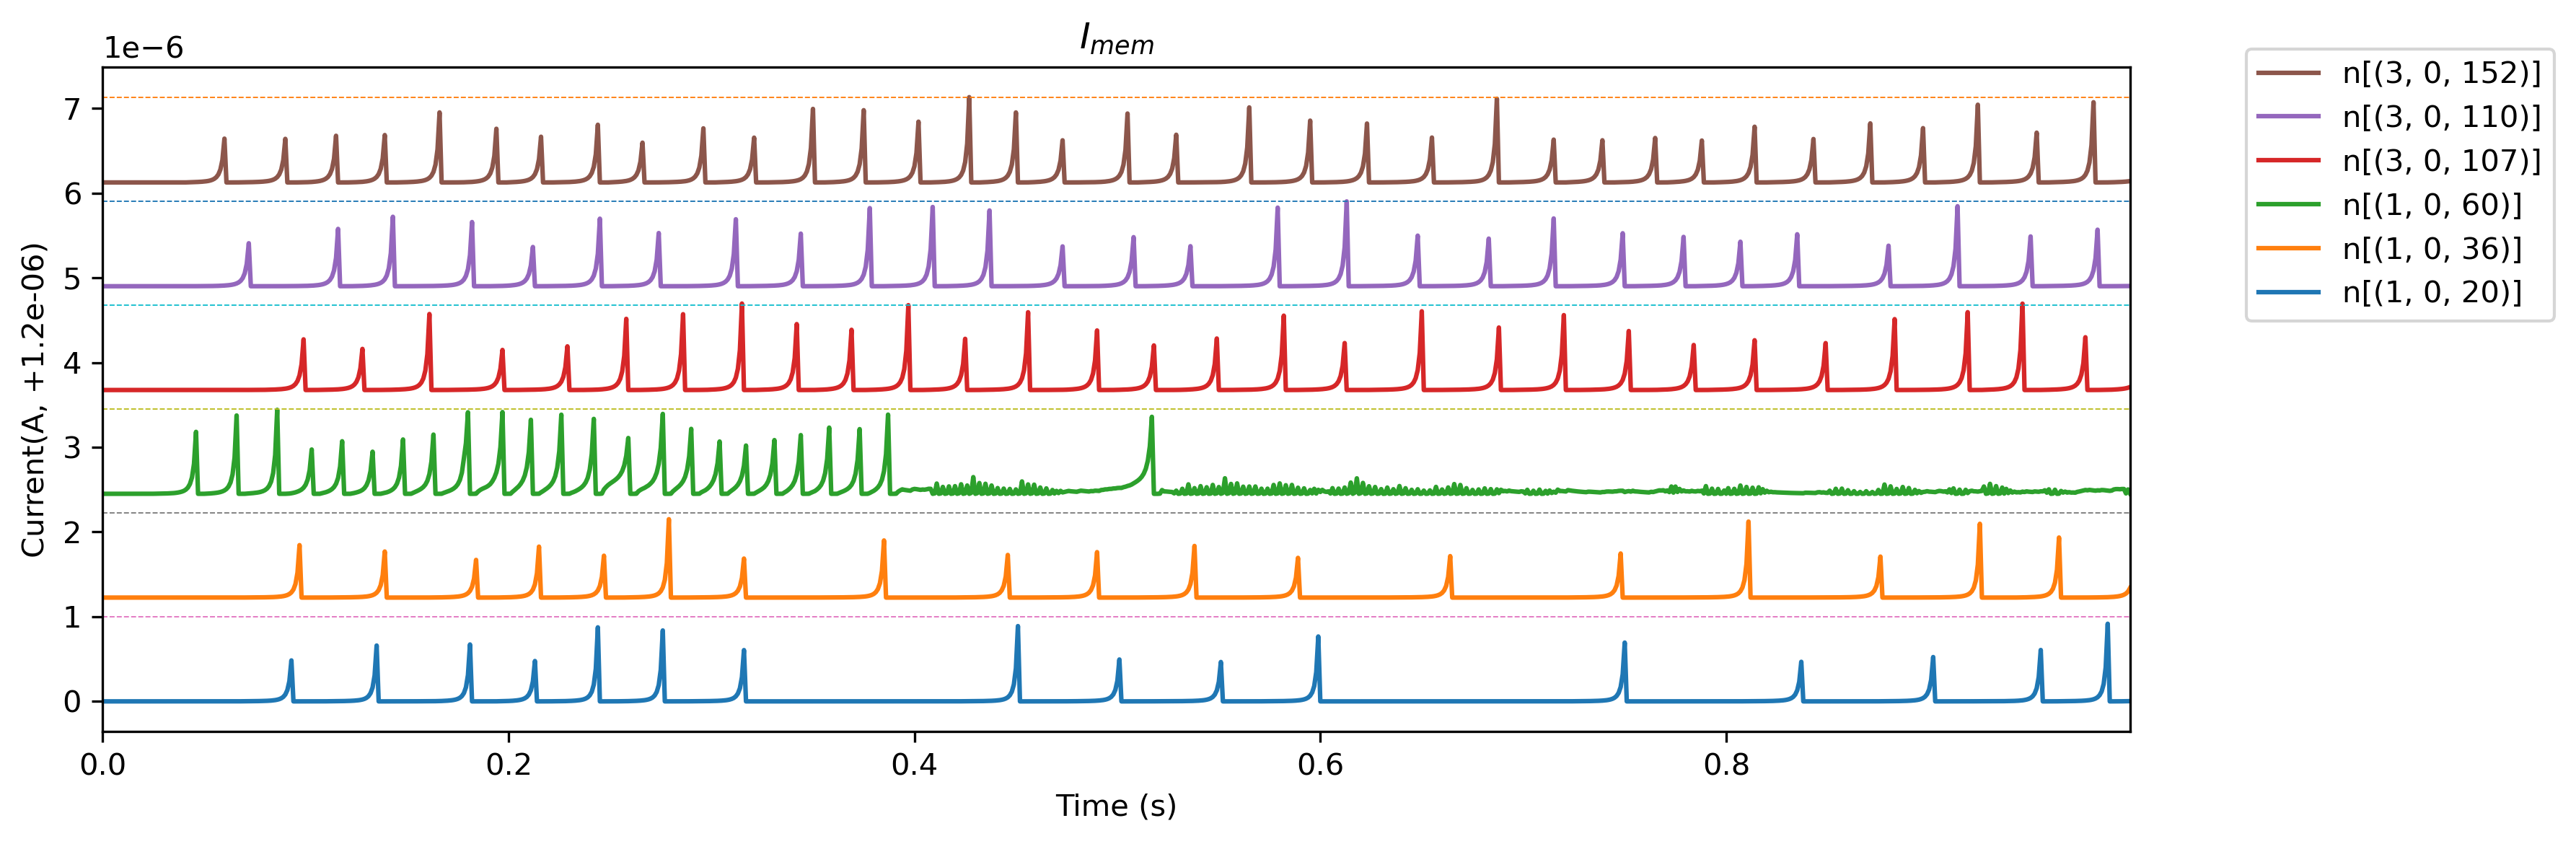

In [13]:
Figure.plot_Ix(rd["imem"], se1.Ispkthr, name="$I_{mem}$", idx_map=router.idx_map)



non-periodic TSContinuous object `$V_{mem}$` from t=0.0 to 1.0. Samples: 1000. Channels: 6

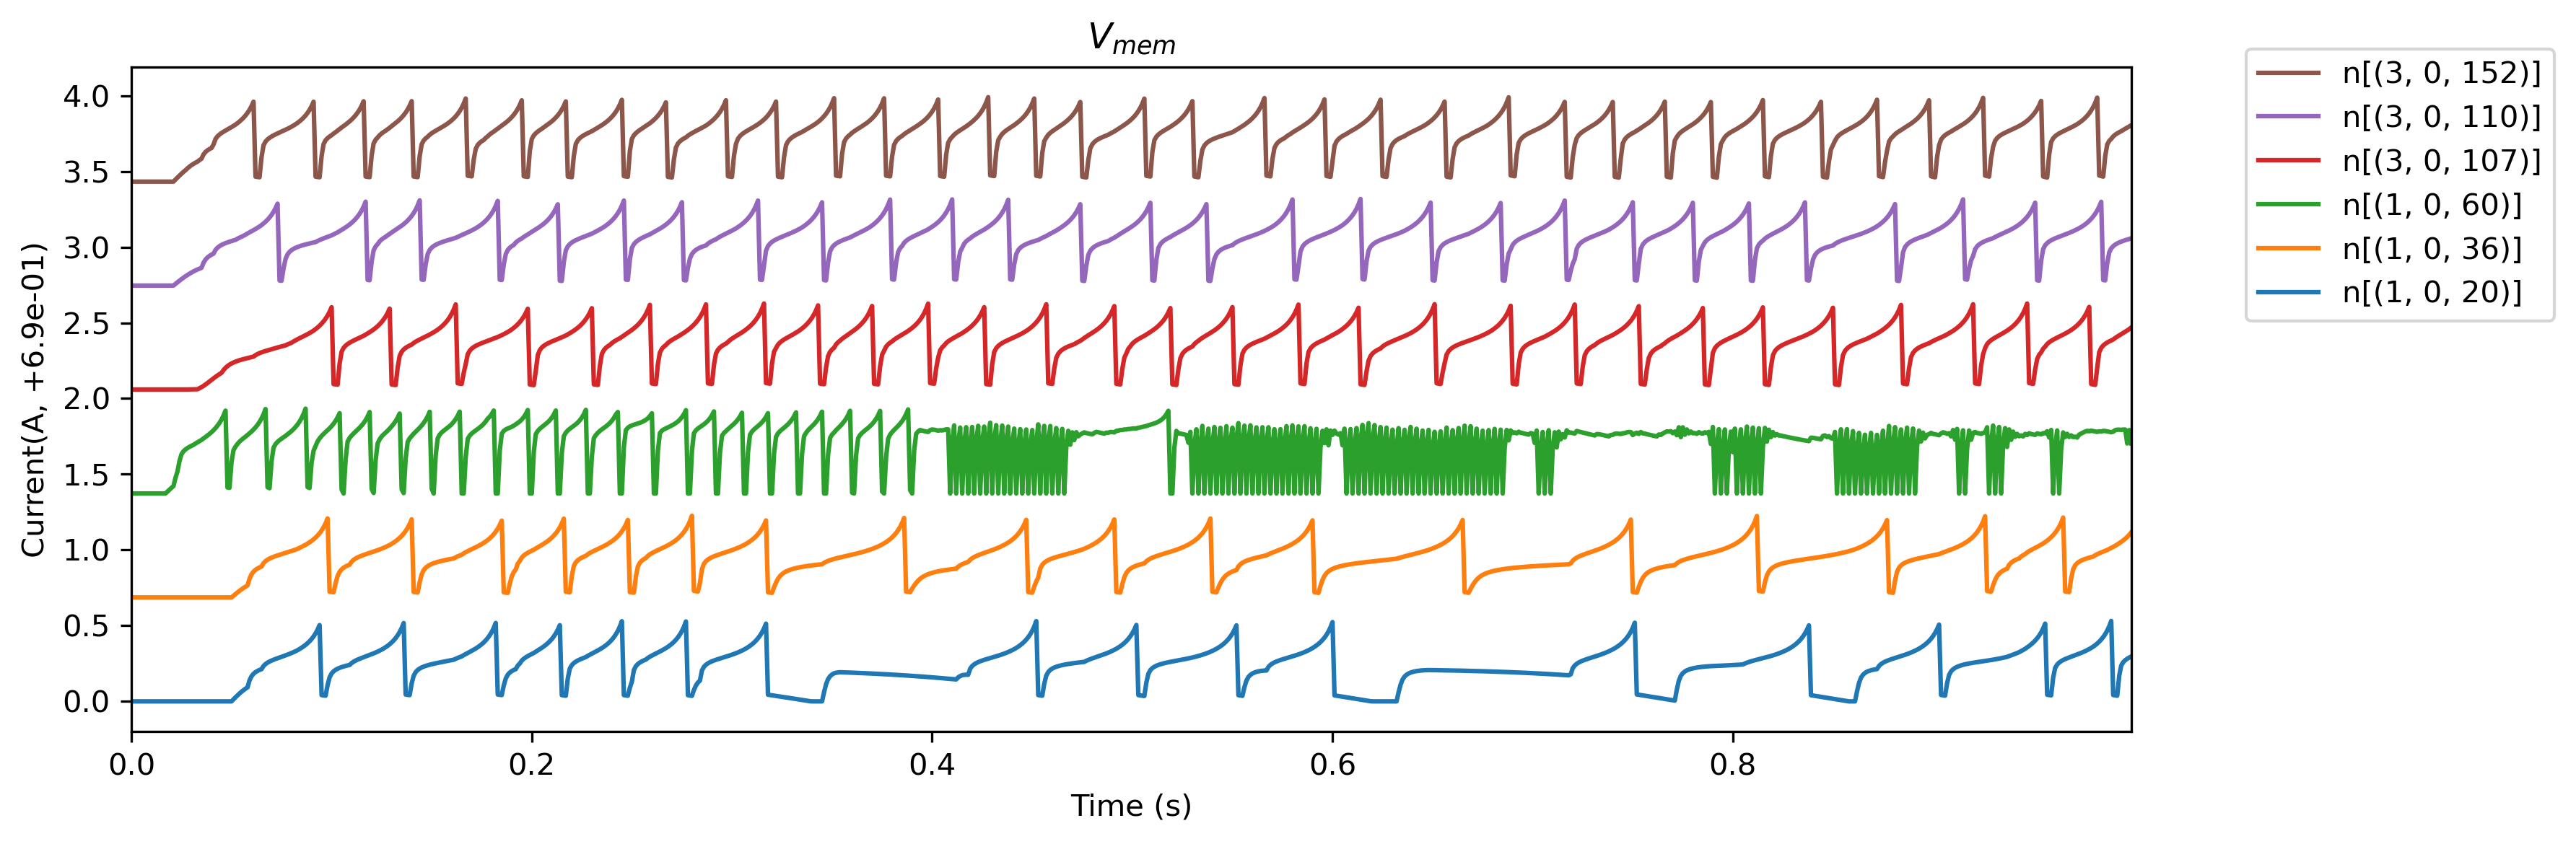

In [14]:
Figure.plot_Ix(rd["vmem"], name="$V_{mem}$", idx_map=router.idx_map)



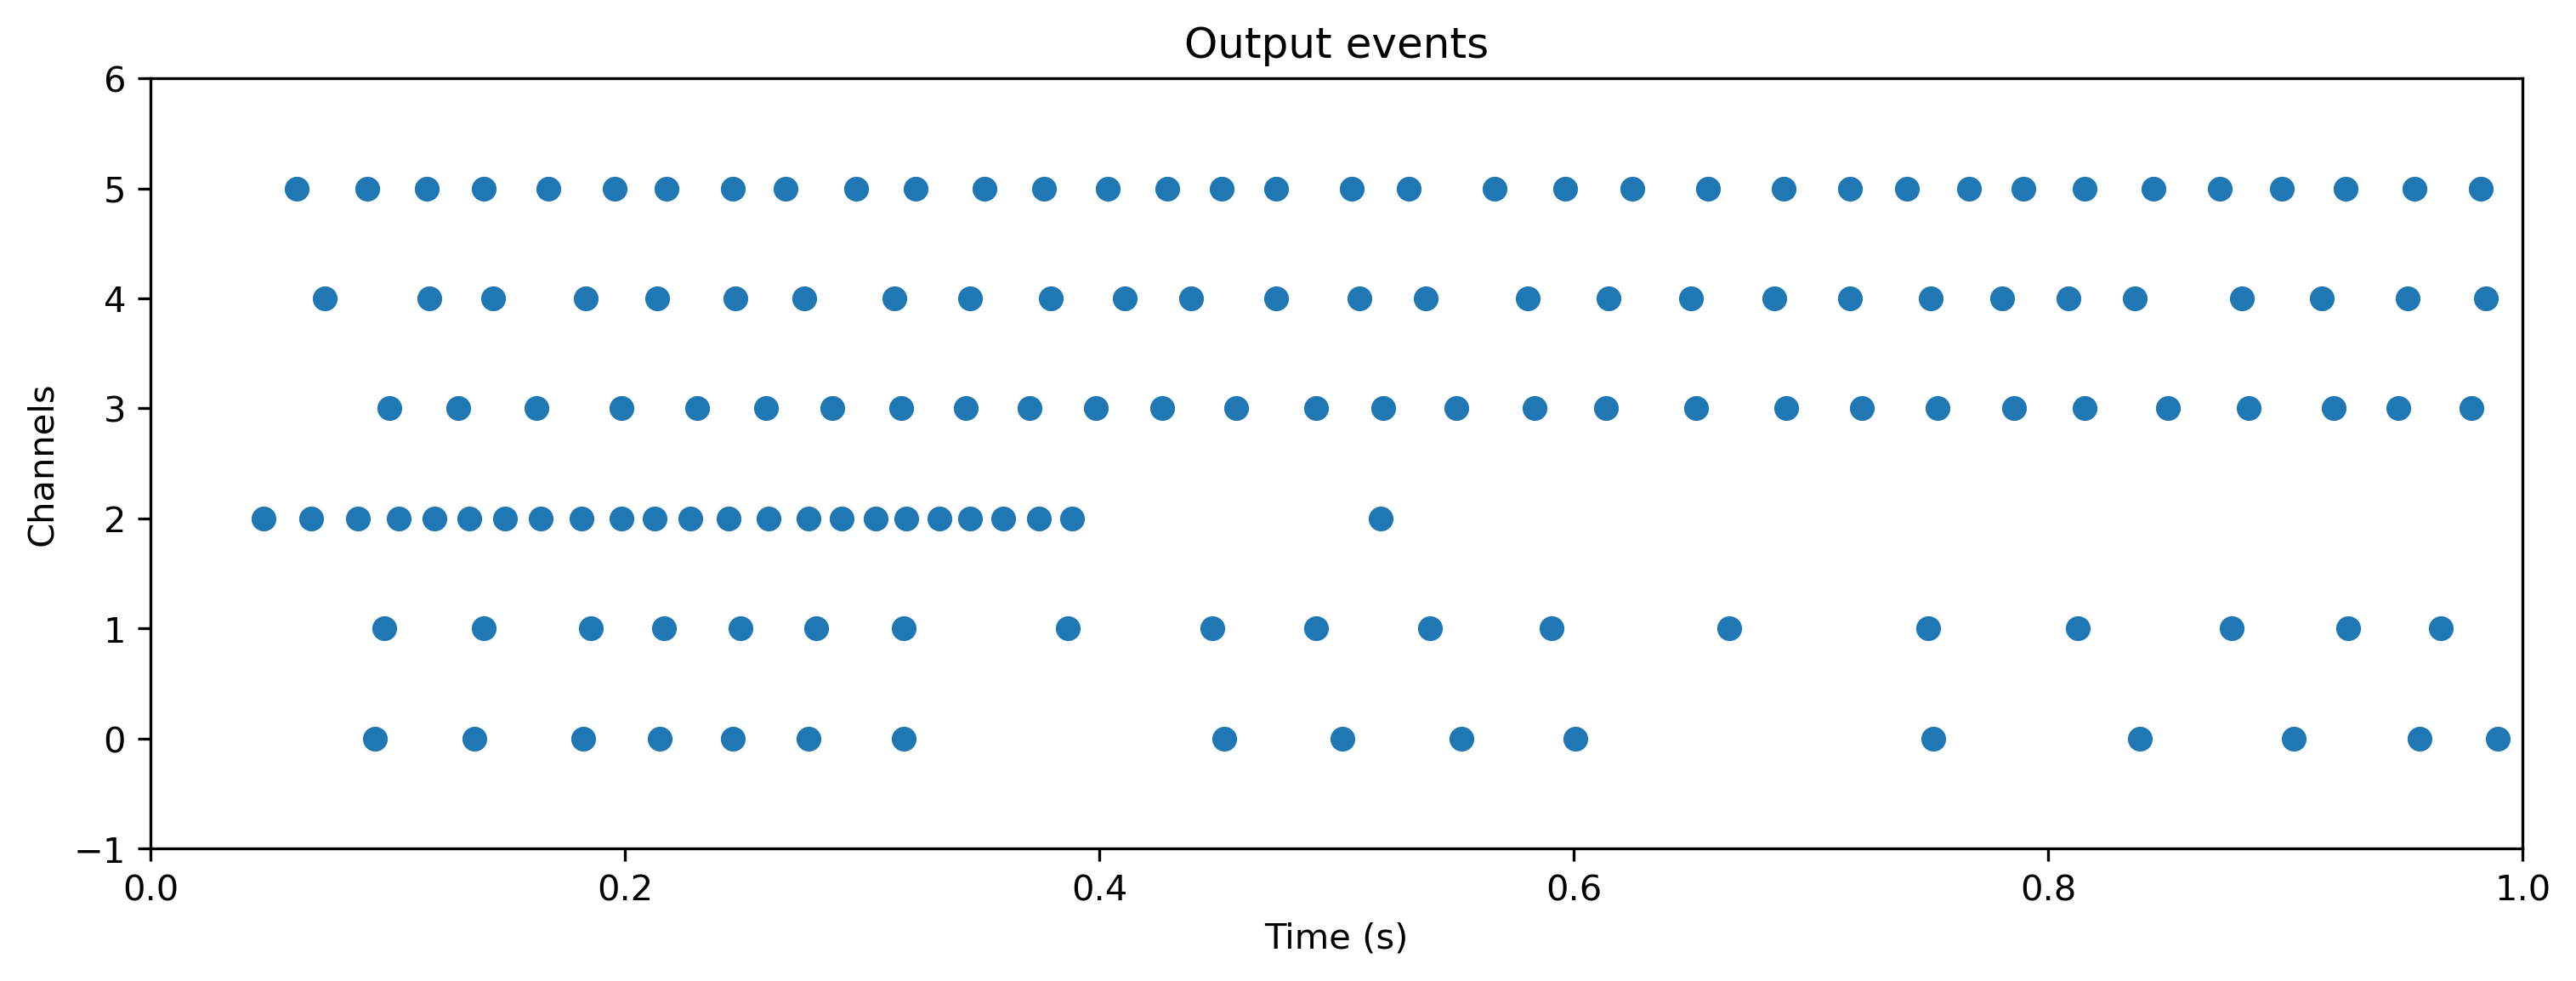

In [15]:
# Figure.plot_spikes(record_dict["1_DynapSim_output"], name="Output Spikes", idx_map=router.idx_map);
out_spikes.plot()



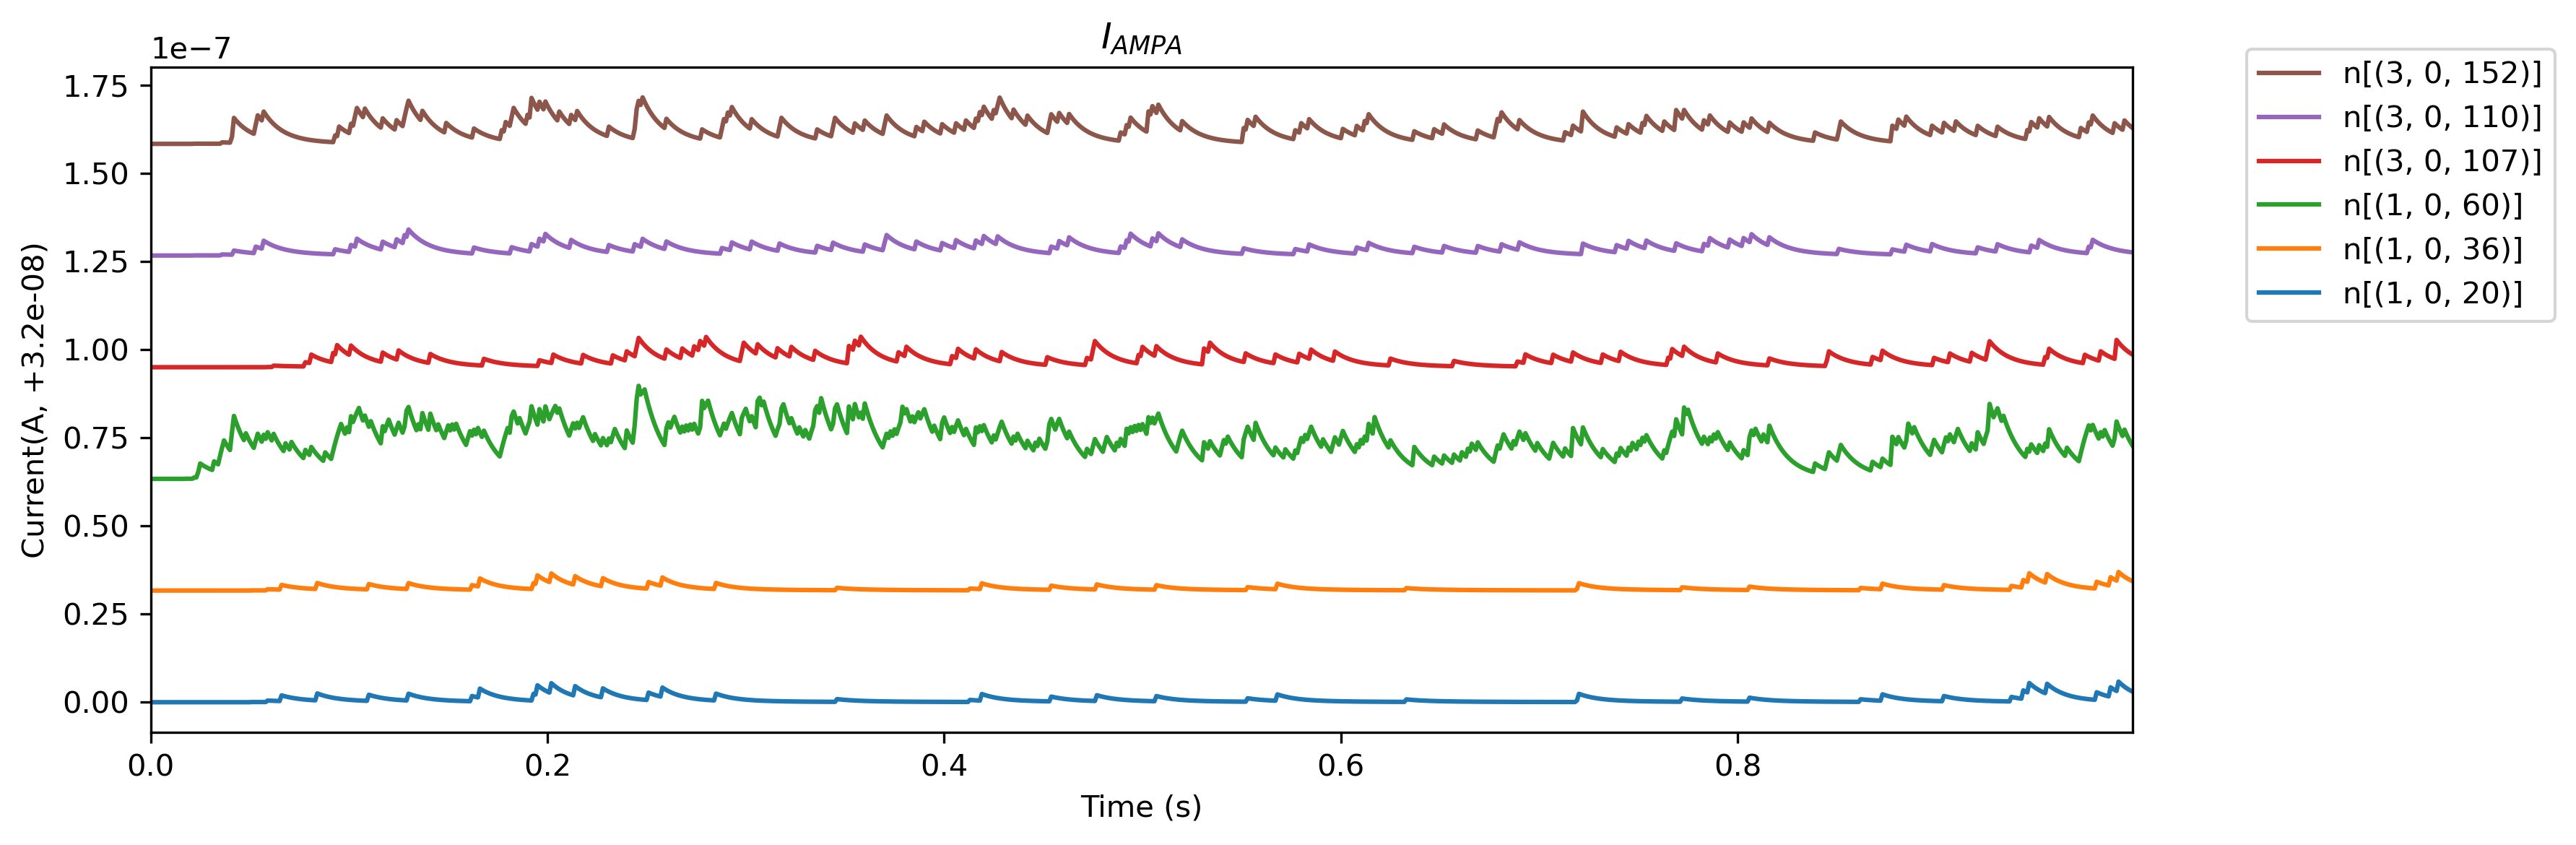

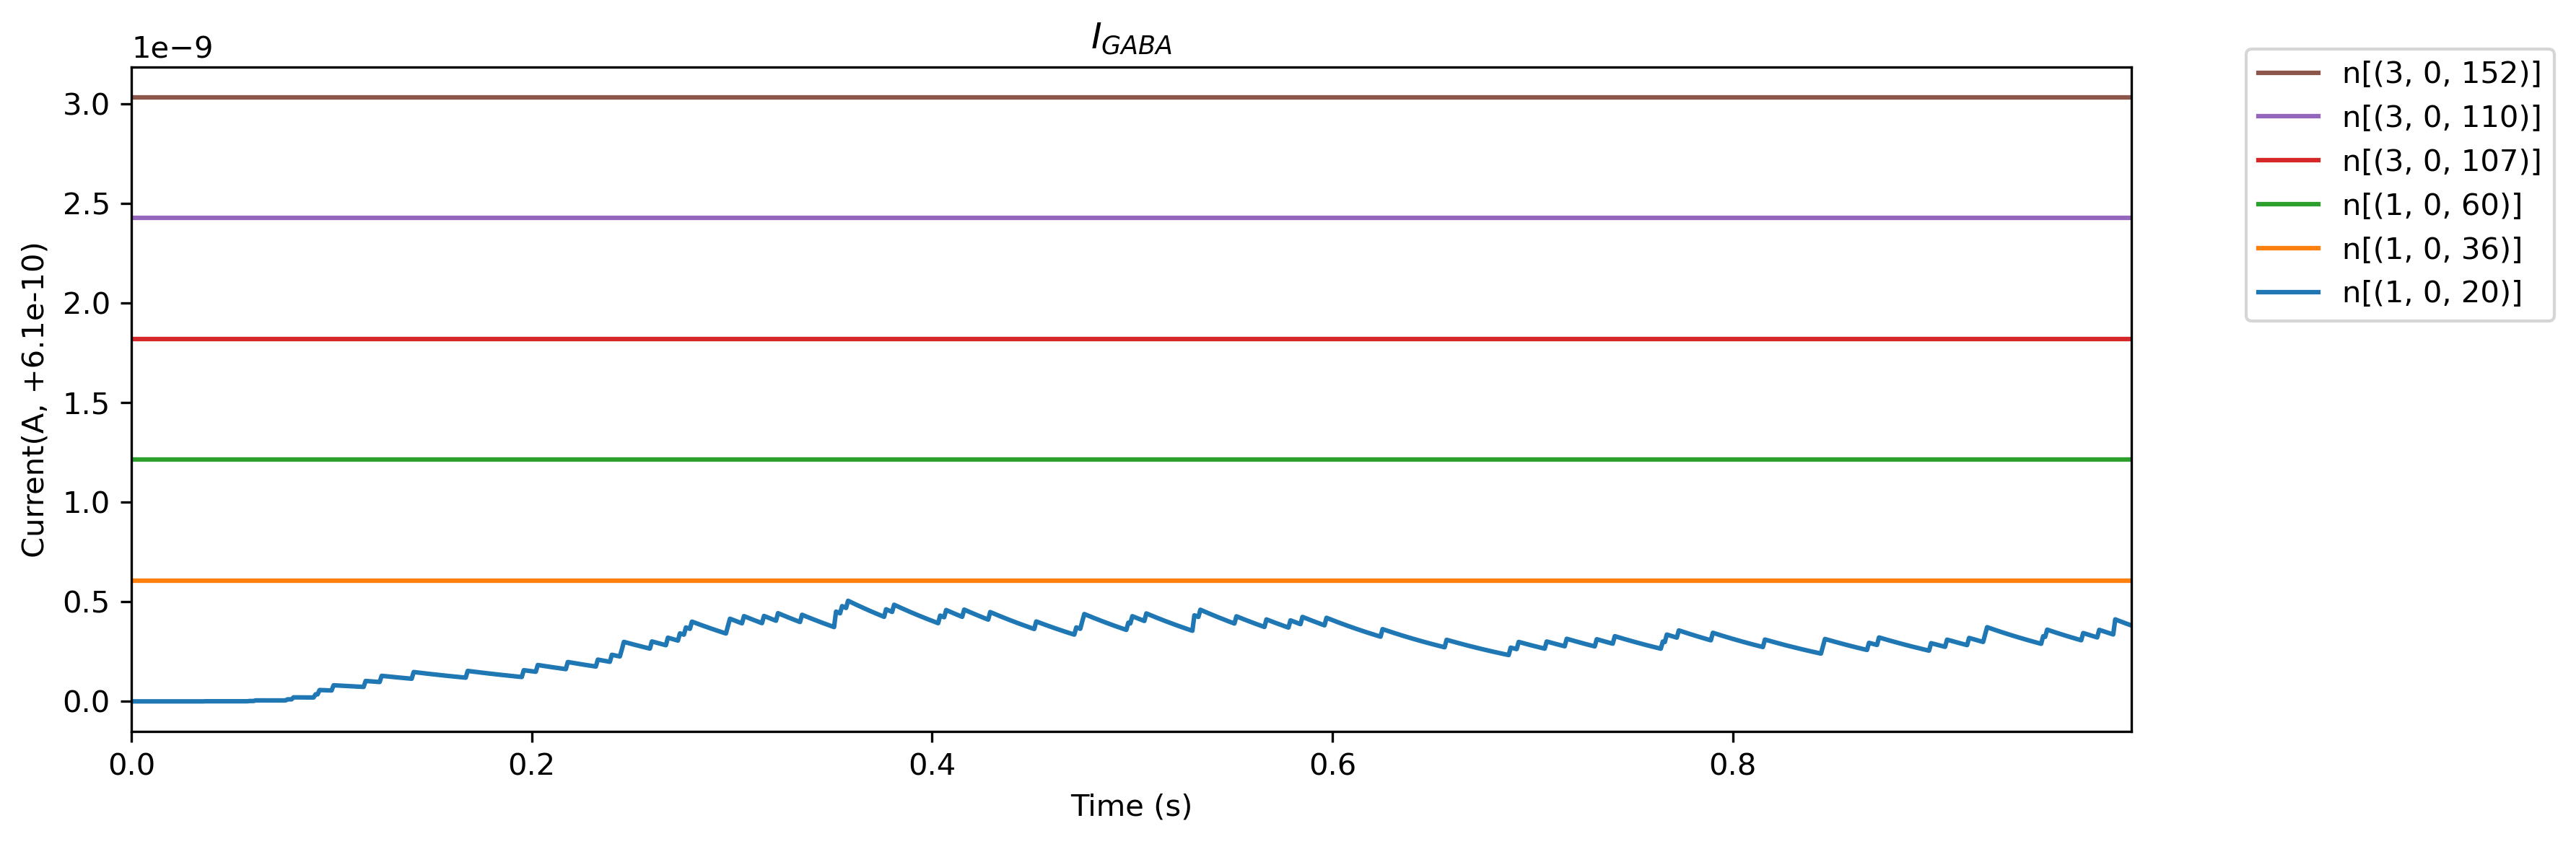

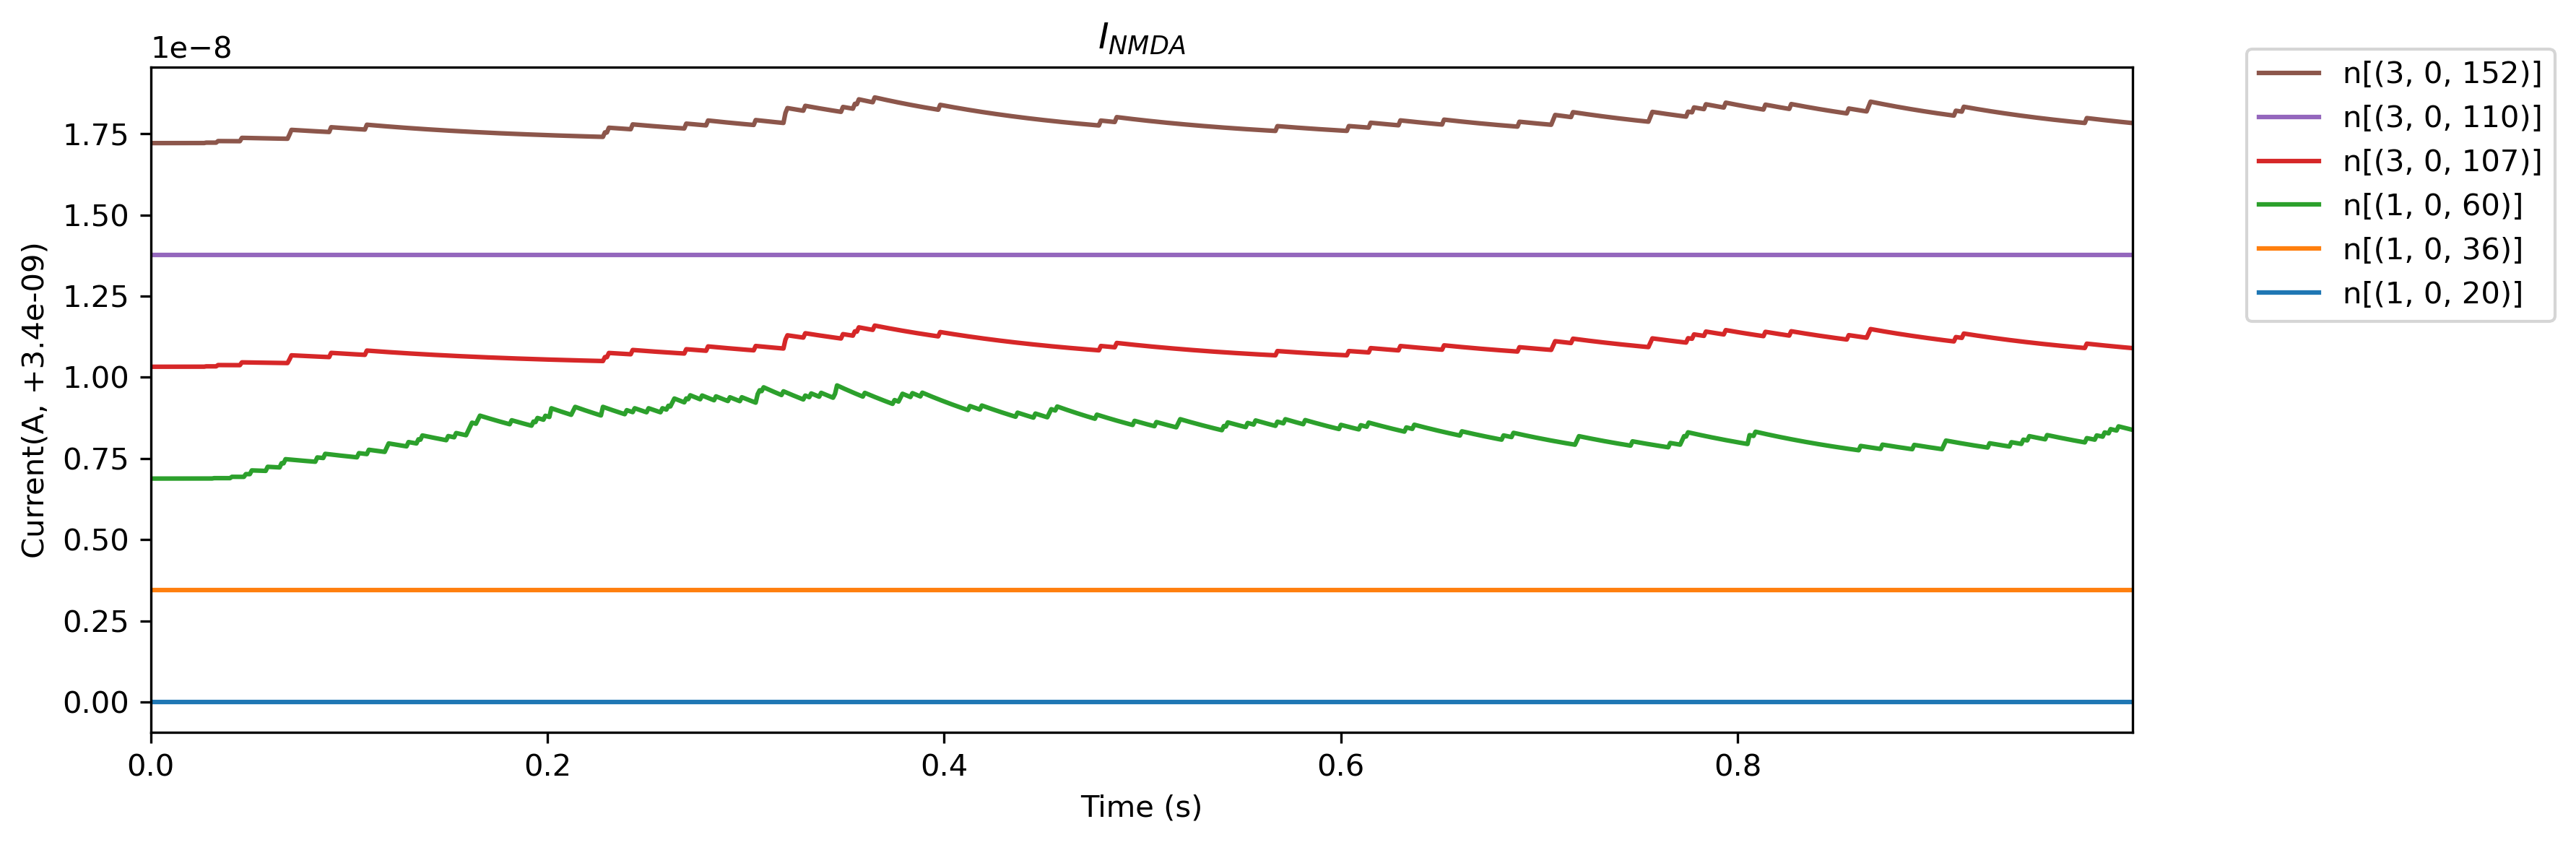

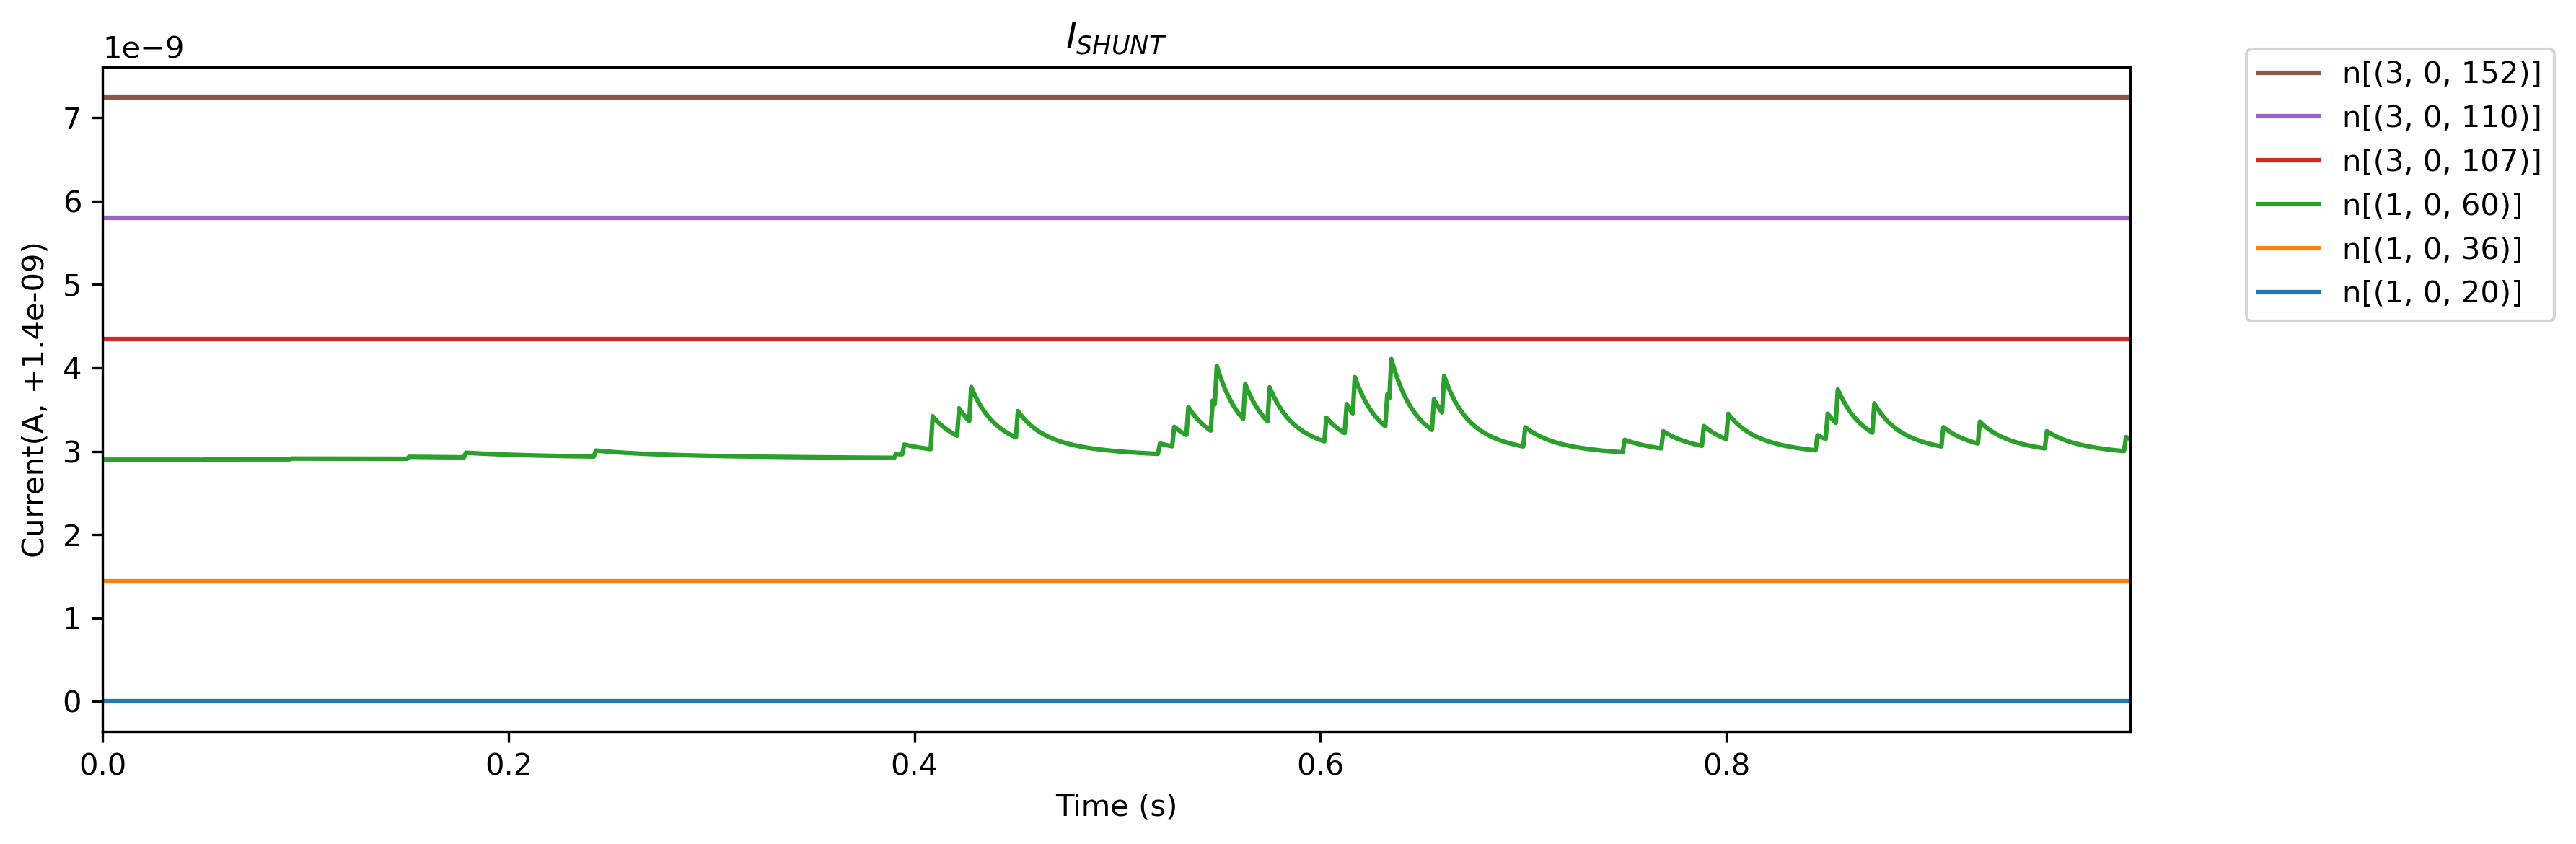

In [16]:
for c in ["AMPA", "GABA", "NMDA", "SHUNT"]:
    plt.figure()
    Figure.plot_Ix(rd[f"i{c.lower()}"], name=f"$I_{{{c}}}$", idx_map=router.idx_map)



non-periodic TSContinuous object `$I_{AHP}$` from t=0.0 to 1.0. Samples: 1000. Channels: 6

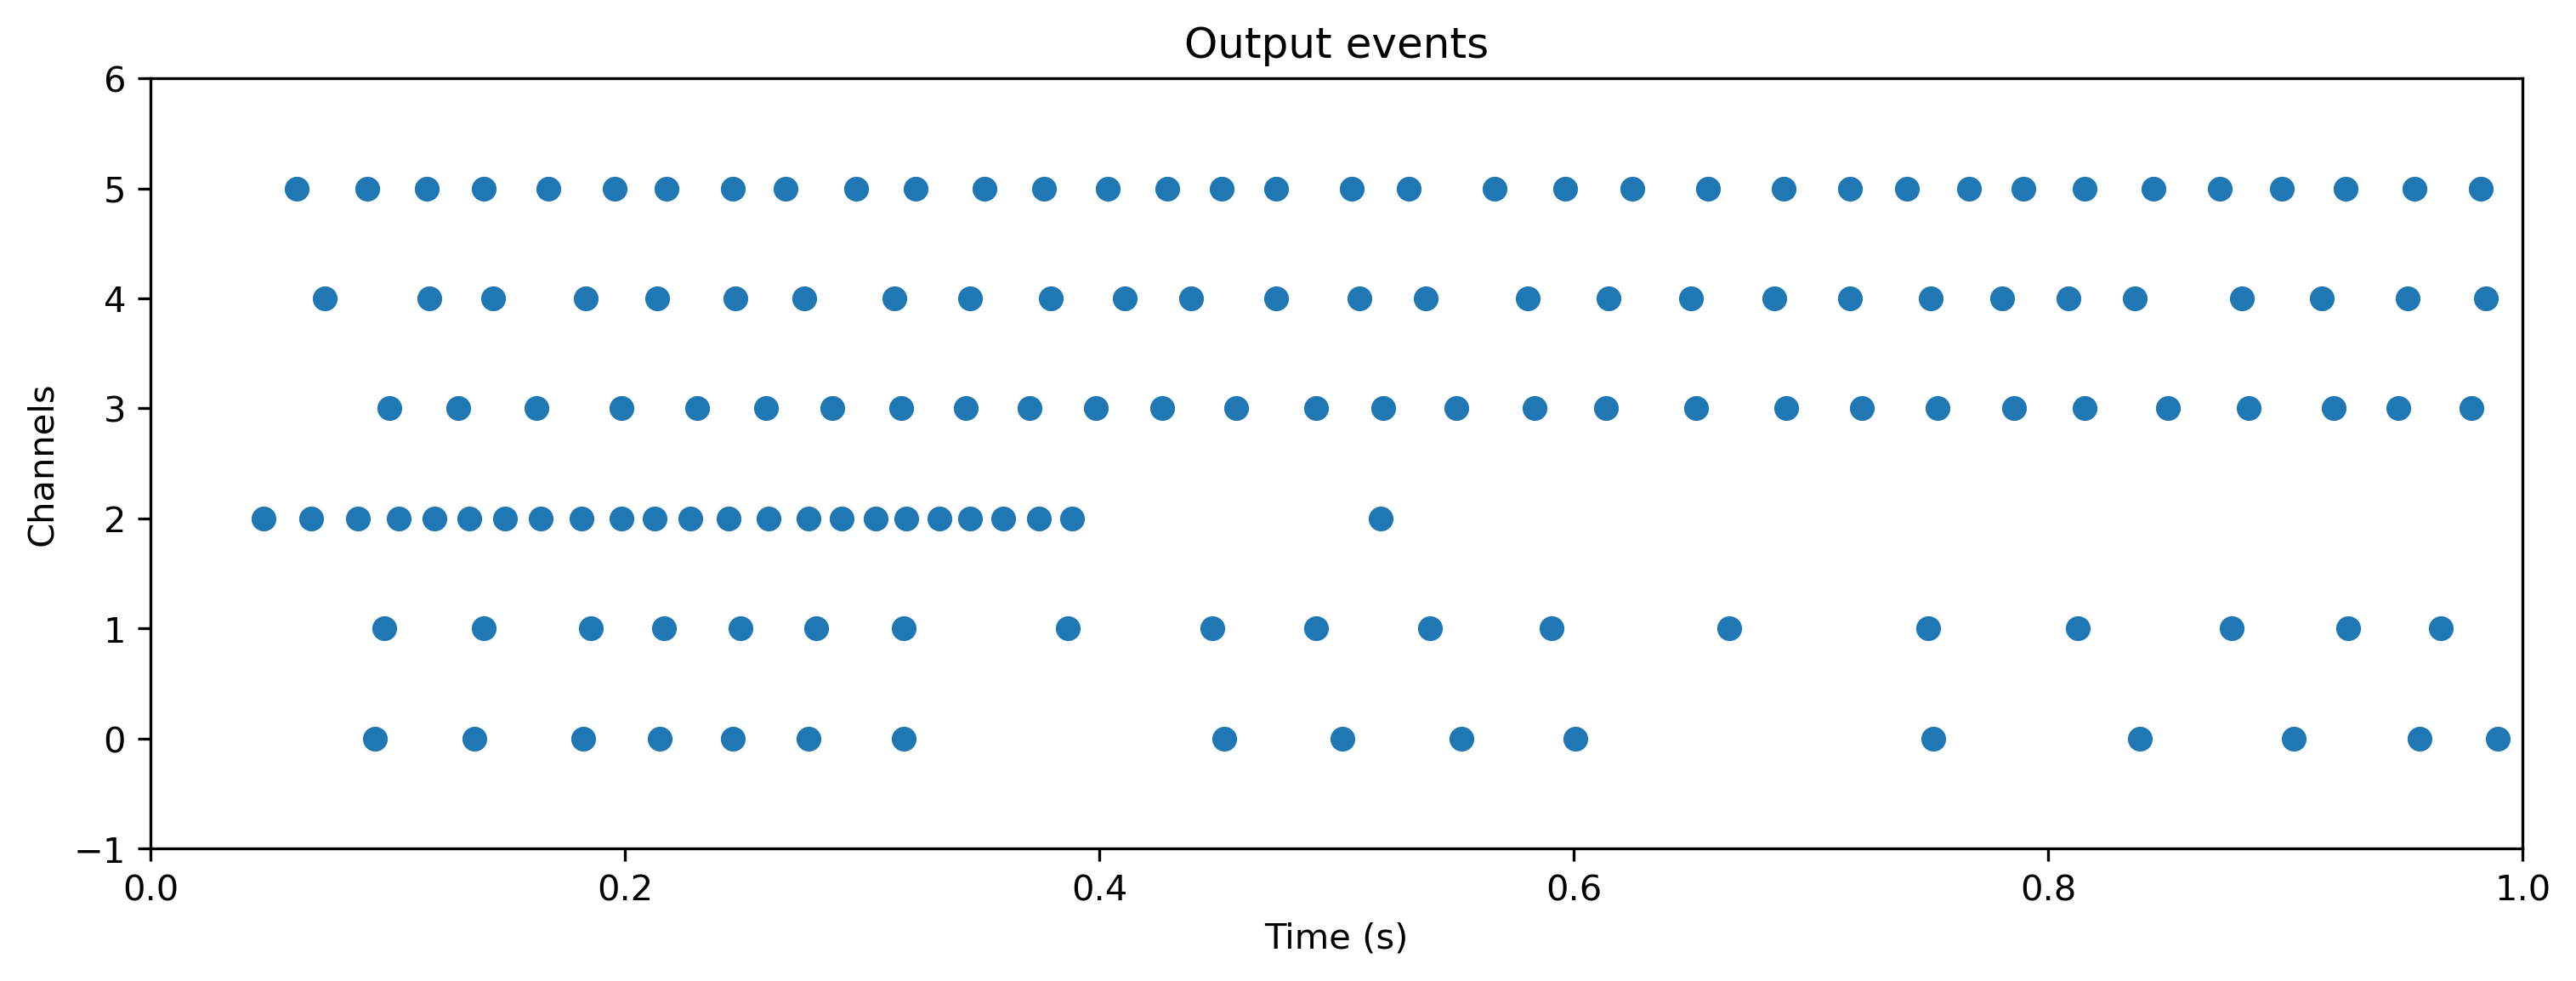

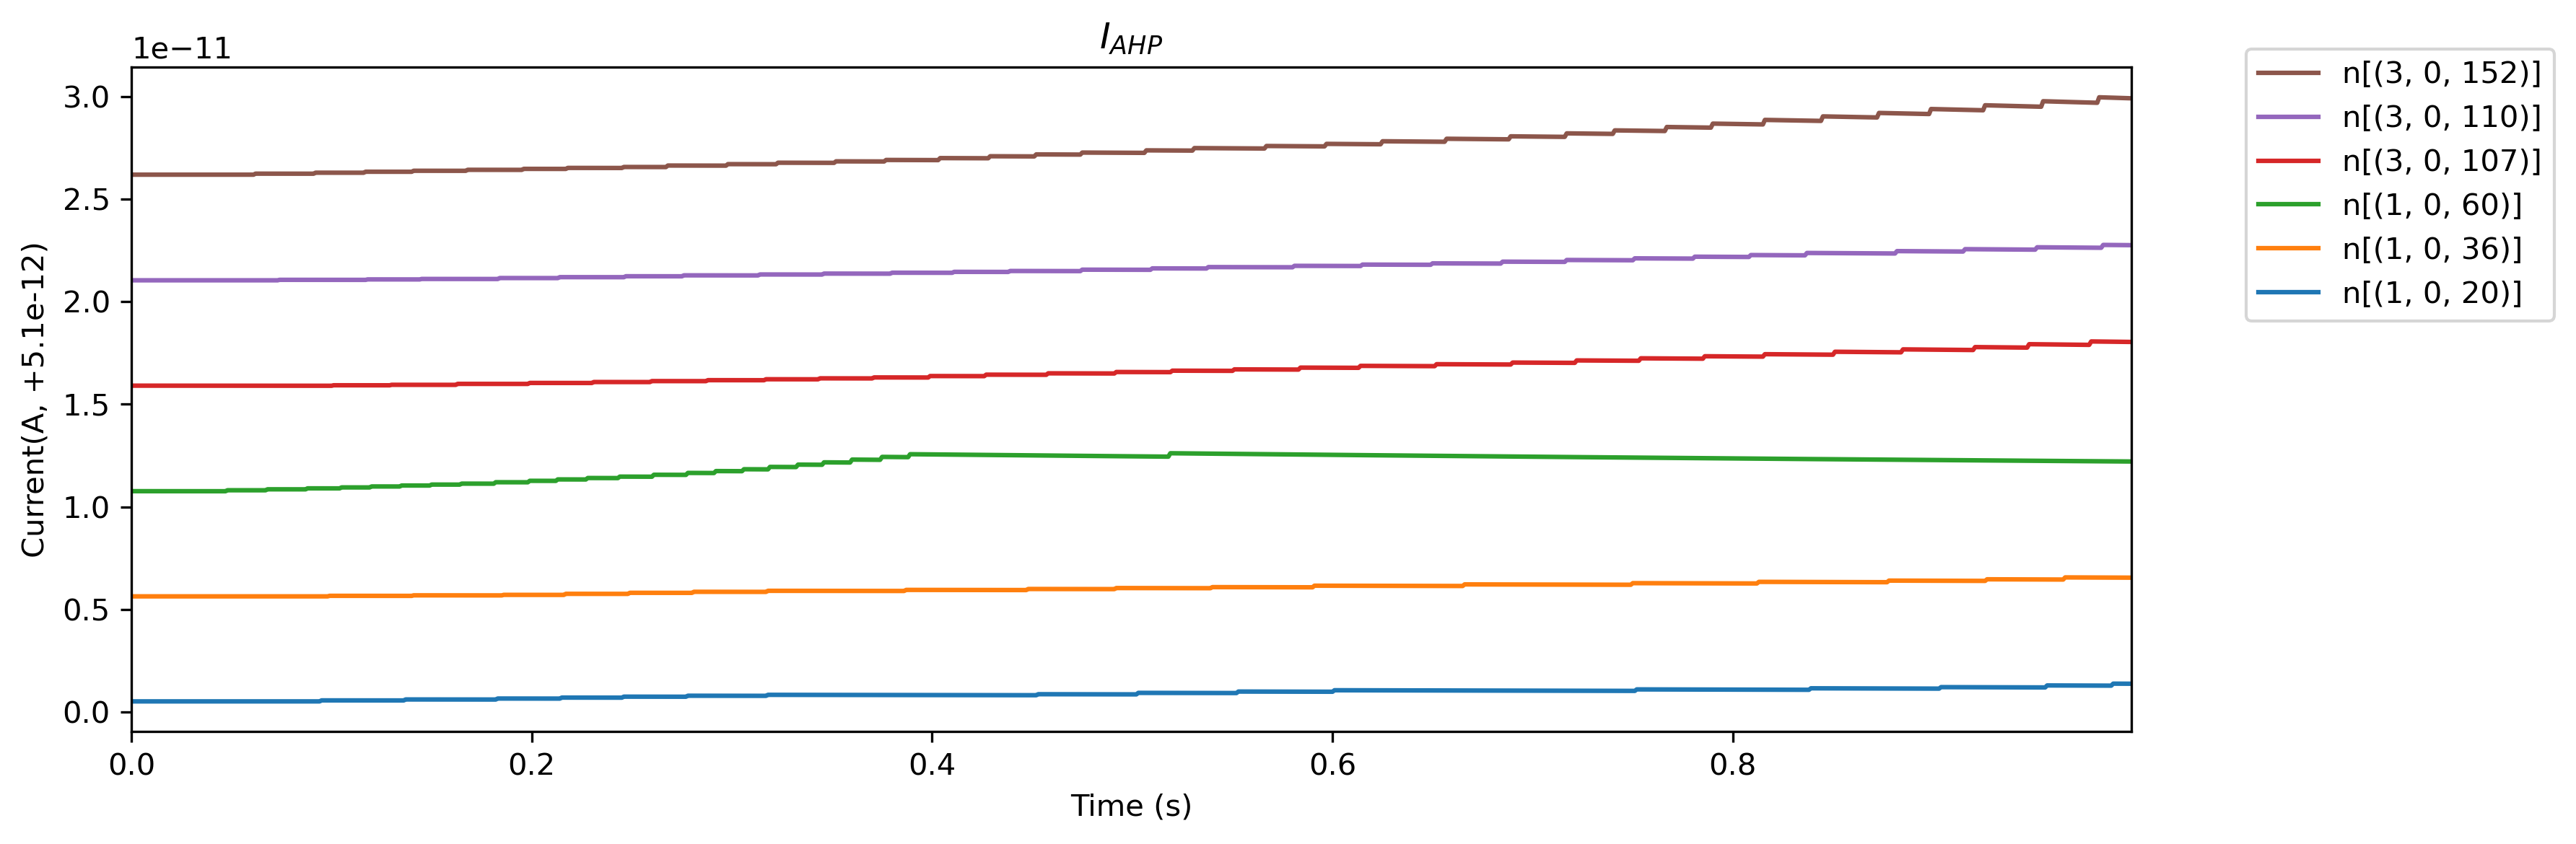

In [17]:
plt.figure()
out_spikes.plot()
plt.figure()
Figure.plot_Ix(rd[f"iahp"], name=f"$I_{{AHP}}$", idx_map=router.idx_map)



In [18]:
router.idx_map


{0: (1, 0, 20),
 1: (1, 0, 36),
 2: (1, 0, 60),
 3: (3, 0, 107),
 4: (3, 0, 110),
 5: (3, 0, 152)}

In [19]:
router.tag_map_in


{0: 20, 1: 36, 2: 50, 3: 59, 4: 60, 5: 78, 6: 107, 7: 152}

(non-periodic TSContinuous object `$I_{NMDA}$ n[(1, 0, 60)]` from t=0.0 to 1.0. Samples: 1000. Channels: 1,
 non-periodic `TSEvent` object `` from t=0.0 to 1.0. Channels: 3. Events: 116,
 ['s[50]x4', 's[60]x4', 'n[(1, 0, 60)]x4'])

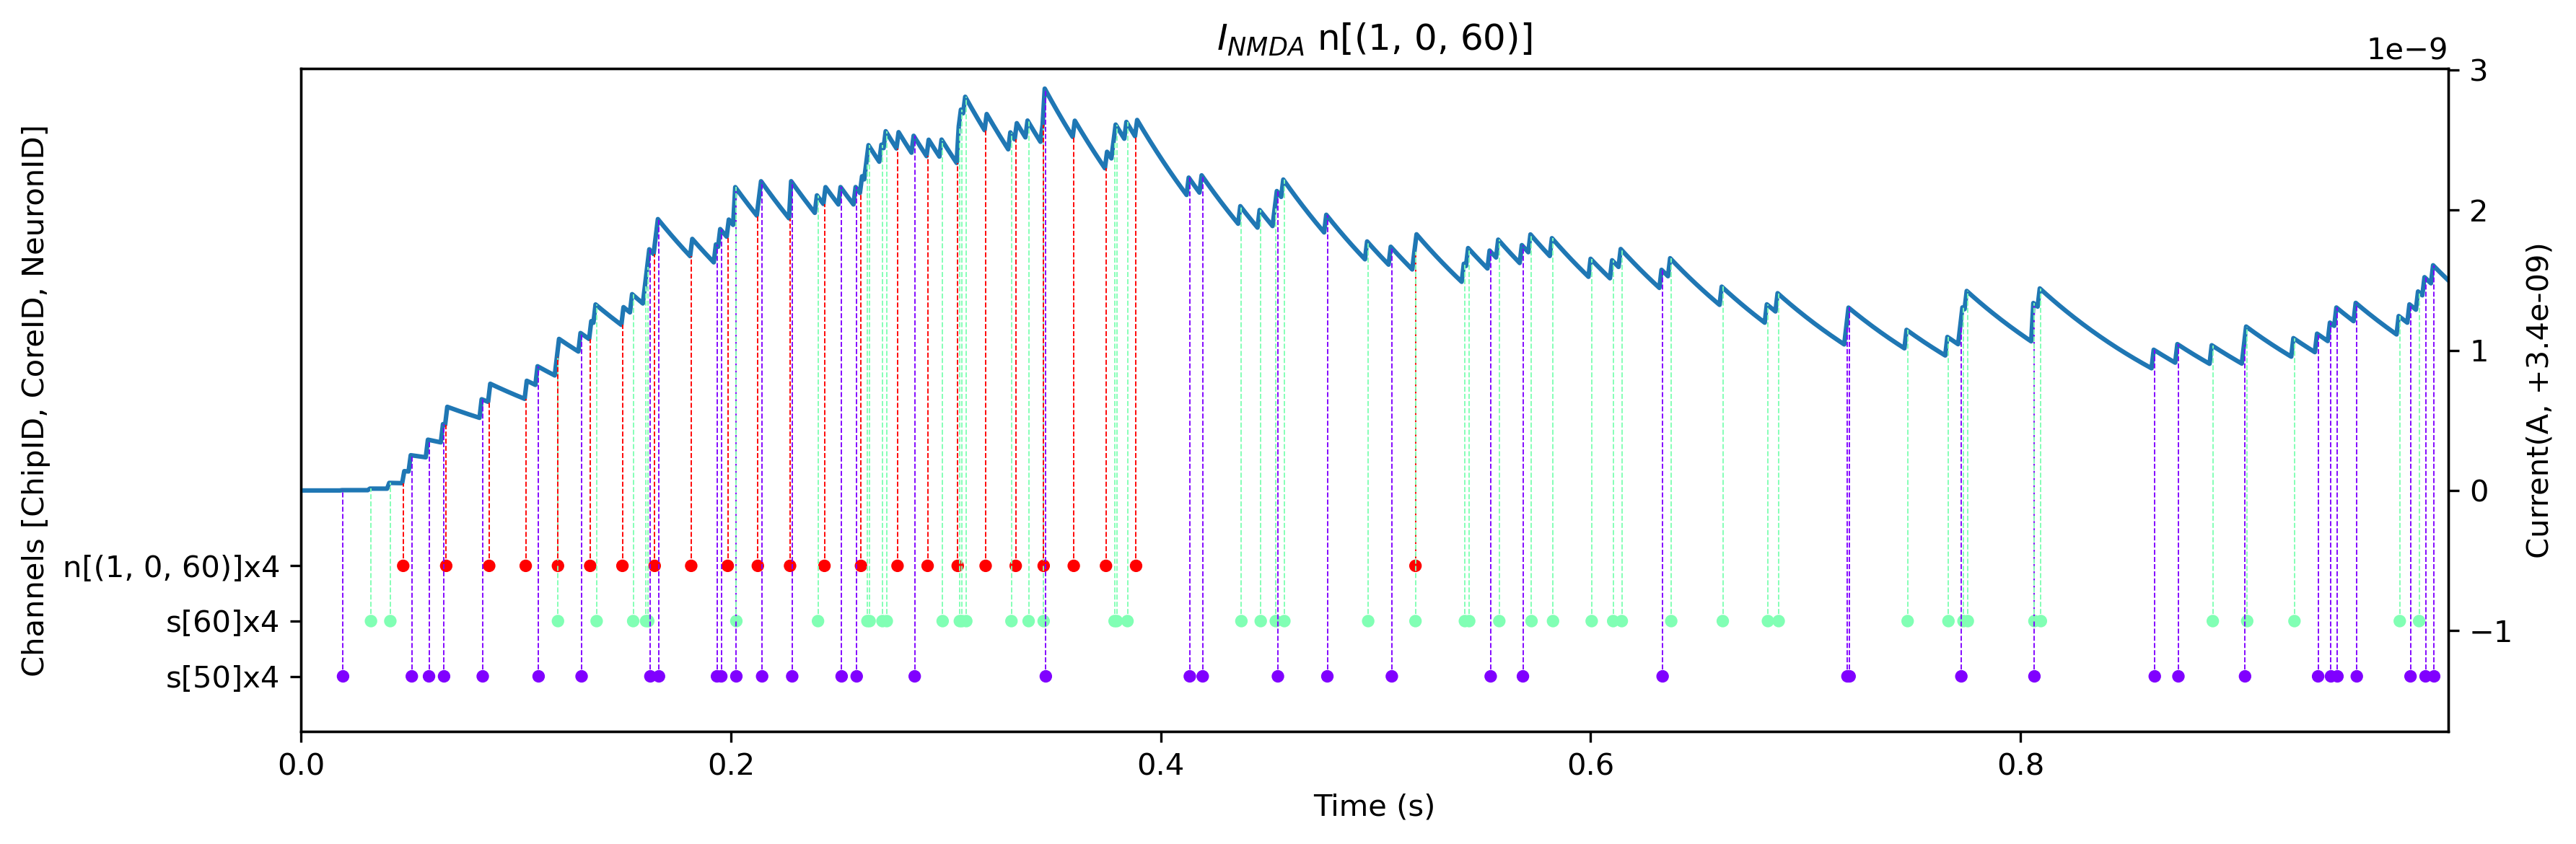

In [20]:
Figure.plot_Isyn_trace(
    input_ts=input_ts,
    output_ts=out_spikes,
    record_dict=record_dict["1_DynapSim"],
    post=(1, 0, 60),
    syn_name="NMDA",
    router=router,
)


(non-periodic TSContinuous object `$I_{AMPA}$ n[(1, 0, 60)]` from t=0.0 to 1.0. Samples: 1000. Channels: 1,
 non-periodic `TSEvent` object `` from t=0.0 to 1.0. Channels: 10. Events: 365,
 ['s[20]x8',
  's[36]x8',
  's[60]x8',
  's[107]x8',
  's[152]x8',
  'n[(1, 0, 20)]x8',
  'n[(1, 0, 36)]x8',
  'n[(1, 0, 60)]x8',
  'n[(3, 0, 107)]x8',
  'n[(3, 0, 152)]x8'])

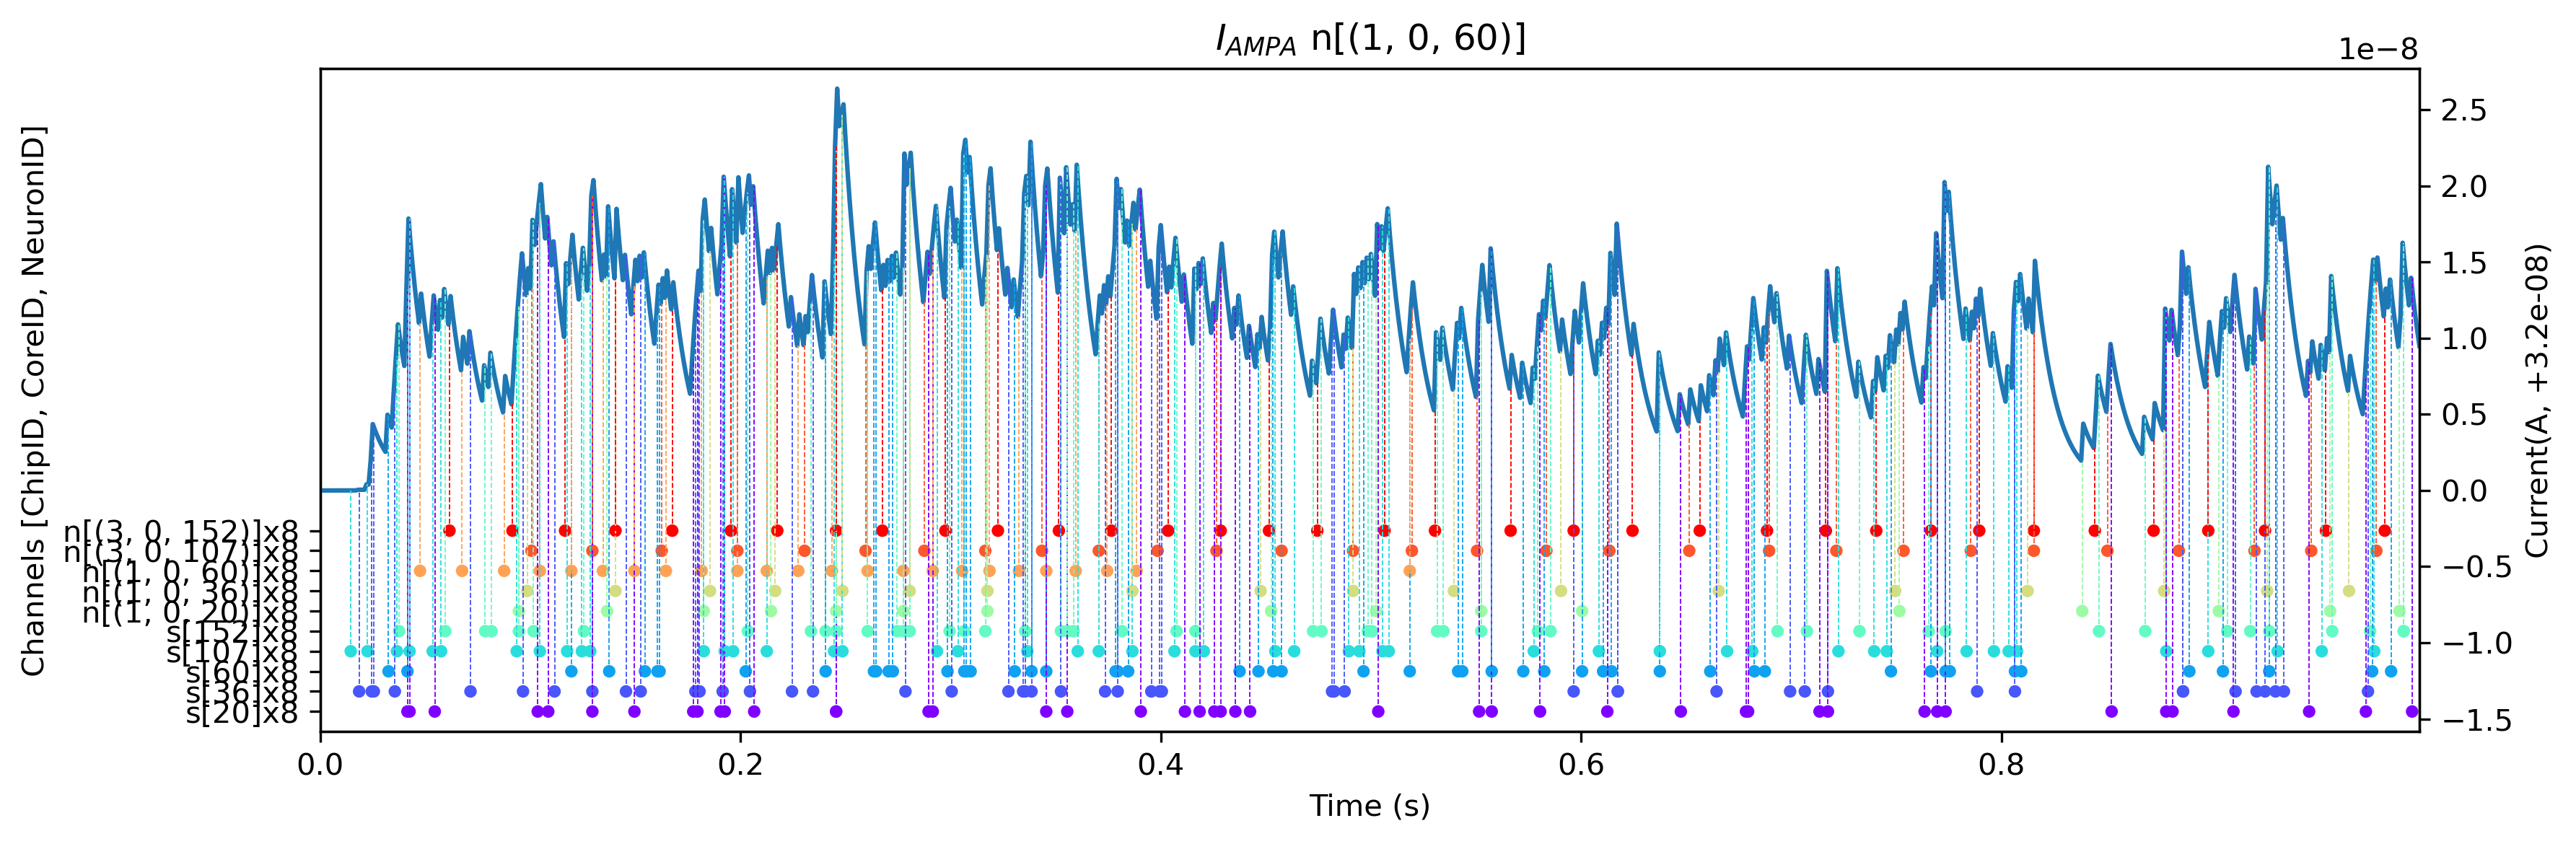

In [21]:
Figure.plot_Isyn_trace(
    input_ts=input_ts,
    output_ts=out_spikes,
    record_dict=record_dict["1_DynapSim"],
    post=(1, 0, 60),
    syn_name="AMPA",
    router=router,
)
